# Alzheimer's Prediction using MMSE Features

In [25]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression tools
from Logistic_bootstrap_metrics import bootstrap_metrics, plot_roc_curve, build_summary_table

# Machine Learning Tools
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, 
    auc
)


import seaborn as sns


## Load and Prepare Data

In [ ]:
# Load dataset
df = pd.read_csv("data/Filtered_Data.csv")

# Split into train and test based on 'Split' column
df_train = df[df['Split'] == 'Train']
df_test = df[df['Split'] == 'Test']

# Define MMSE question columns
mmse_cols = [
    "MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE",
    "MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR",

    "WORD1", "WORD2", "WORD3",

    "MMD", "MML", "MMR", "MMO", "MMW",

    "WORD1DL", "WORD2DL", "WORD3DL",

    "MMWATCH", "MMPENCIL", "MMREPEAT",
    "MMHAND", "MMFOLD", "MMONFLR",
    "MMREAD", "MMWRITE", "MMDRAW"
]

# Define MMSE question categories
categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Registration": ["WORD1", "WORD2", "WORD3"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE"],
    "Copy": ["MMDRAW"]
}

# Significant categories
significant_categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE"]
}

# Updated siginificant categories (With good questions)
updated_categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMREPEAT"]
}

# BioBERT embeddings
df_numerical_biobert_train = pd.read_csv("data/Embeddings/Numerical_BioBERT_Train.csv")
df_numerical_biobert_test = pd.read_csv("data/Embeddings/Numerical_BioBERT_Test.csv")
df_biobert_train = pd.read_csv("data/Embeddings/BioBERT_Train.csv")
df_biobert_test = pd.read_csv("data/Embeddings/BioBERT_Test.csv")
df_context_biobert_test = pd.read_csv("data/Embeddings/Context_BioBERT_Train.csv")
df_context_biobert_train = pd.read_csv("data/Embeddings/Context_BioBERT_Test.csv")

# ClinicalBERT embeddings
df_numerical_clinicalbert_train = pd.read_csv("data/Embeddings/Numerical_ClinicalBERT_Train.csv")
df_numerical_clinicalbert_test = pd.read_csv("data/Embeddings/Numerical_ClinicalBERT_Test.csv")
df_clincalbert_train = pd.read_csv("data/Embeddings/ClinicalBERT_Train.csv")
df_clincalbert_test = pd.read_csv("data/Embeddings/ClinicalBERT_Test.csv")
df_context_clinicalbert_test = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Train.csv")
df_context_clinicalbert_train = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Test.csv")

# MedBERT embeddings
df_numerical_medbert_train = pd.read_csv("data/Embeddings/Numerical_MedBERT_Train.csv")
df_numerical_medbert_test = pd.read_csv("data/Embeddings/Numerical_MedBERT_Test.csv")
df_medbert_train = pd.read_csv("data/Embeddings/MedBERT_Train.csv")
df_medbert_test = pd.read_csv("data/Embeddings/MedBERT_Test.csv")
df_context_medbert_test = pd.read_csv("data/Embeddings/Context_MedBERT_Train.csv")
df_context_medbert_train = pd.read_csv("data/Embeddings/Context_MedBERT_Test.csv")


## Helper Functions

In [27]:
def prepare_features_for_logistic_regression(X_train, X_test, variance_threshold=1e-5, correlation_threshold=0.98):
    
    # Step 1: Remove constant (zero variance) features
    selector = VarianceThreshold(threshold=variance_threshold)
    X_train_reduced = selector.fit_transform(X_train)
    X_test_reduced = selector.transform(X_test)

    kept_features = X_train.columns[selector.get_support()]
    X_train_reduced = pd.DataFrame(X_train_reduced, columns=kept_features, index=X_train.index)
    X_test_reduced = pd.DataFrame(X_test_reduced, columns=kept_features, index=X_test.index)

    # Step 2: Remove highly correlated features
    corr_matrix = X_train_reduced.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    X_train_final = X_train_reduced.drop(columns=to_drop, errors='ignore')
    X_test_final = X_test_reduced.drop(columns=to_drop, errors='ignore')

    return X_train_final, X_test_final

def run_logistic_regression_pipeline(train_df, test_df, embedding_cols, categories, model_name="ClinicalBERT", target_var='AD', n_bootstrap=1000):

    # # --- Per category logistic regression ---
    # category_results = []
    # for category_name, mmse_codes in categories.items():
    #     print(f"\nRunning logistic regression for {model_name} - Category: {category_name}")

    #     train_filtered = train_df[train_df['MMSE Code'].isin(mmse_codes)]
    #     test_filtered = test_df[test_df['MMSE Code'].isin(mmse_codes)]

    #     if len(train_filtered) < 10 or len(test_filtered) < 10:
    #         print(f"Skipping {category_name} (not enough samples)")
    #         continue

    #     X_train = train_filtered[embedding_cols]
    #     y_train = train_filtered[target_var]
    #     X_test = test_filtered[embedding_cols]
    #     y_test = test_filtered[target_var]

    #     result = bootstrap_metrics(
    #         df_train=X_train,
    #         df_test=X_test,
    #         independent_vars=embedding_cols,
    #         dep_var_train=y_train,
    #         dep_var_test=y_test,
    #         n_bootstrap=n_bootstrap
    #     )

    #     category_results.append({
    #         'Category': category_name,
    #         'Best Threshold': result["Best Threshold"],
    #         'Odds Ratios': result["Odds Ratios (one-time fit)"],
    #         'Bootstrapped Metrics': result["Bootstrapped Metrics"],
    #         'True Labels': result["True Labels"],
    #         'Predicted Probabilities': result["Predicted Probabilities"]
    #     })

    # --- Combined model: mean embeddings per category ---
    print(f"\nRunning combined logistic regression for {model_name} (mean embeddings per category)")

    def compute_category_means(df, embedding_cols, mmse_codes_dict):
        category_mean_features = pd.DataFrame(index=df['subject_id'].unique())
        for category, codes in mmse_codes_dict.items():
            filtered = df[df['MMSE Code'].isin(codes)]
            if not filtered.empty:
                mean_embeddings = filtered.groupby('subject_id')[embedding_cols].mean()
                mean_embeddings = mean_embeddings.add_prefix(f"{category}_")
                category_mean_features = category_mean_features.join(mean_embeddings, how='left')
        return category_mean_features

    train_df['subject_id'] = train_df['subject_id'].astype(str)
    test_df['subject_id'] = test_df['subject_id'].astype(str)

    train_means = compute_category_means(train_df, embedding_cols, categories)
    test_means = compute_category_means(test_df, embedding_cols, categories)

    train_labels = train_df[['subject_id', target_var]].drop_duplicates().set_index('subject_id')
    test_labels = test_df[['subject_id', target_var]].drop_duplicates().set_index('subject_id')

    train_means = train_means.join(train_labels).dropna()
    test_means = test_means.join(test_labels).dropna()

    X_train_combined = train_means.drop(columns=[target_var])
    y_train_combined = train_means[target_var]
    X_test_combined = test_means.drop(columns=[target_var])
    y_test_combined = test_means[target_var]

    X_train_final, X_test_final = prepare_features_for_logistic_regression(X_train_combined, X_test_combined)


    combined_result = bootstrap_metrics(
        df_train=X_train_final,
        df_test=X_test_final,
        independent_vars=X_train_final.columns.tolist(),
        dep_var_train=y_train_combined,
        dep_var_test=y_test_combined,
        n_bootstrap=n_bootstrap
    )

    # # Printing results for each category
    # for result in category_results:
    #     print(f"\n=== Results for {model_name} - Category: {result['Category']} ===")
    #     print("\n----- Odds Ratios (one-time fit) -----")
    #     print(result["Odds Ratios"])
    #     print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
    #     print("\n----- Bootstrapped Metrics (1000 runs) -----")
    #     for metric, (mean, ci) in result["Bootstrapped Metrics"].items():
    #         print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # --- Final prints ---
    print(f"\n=== Combined Results for {model_name} ===")
    print("\n----- Odds Ratios (one-time fit) -----")
    print(combined_result["Odds Ratios (one-time fit)"])
    print(f"\nBest Threshold Automatically Found: {combined_result['Best Threshold']:.2f}")
    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in combined_result["Bootstrapped Metrics"].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

    plot_roc_curve(combined_result["True Labels"], combined_result["Predicted Probabilities"], title=f"ROC Curve - {model_name} Combined")

    return combined_result

def drop_highly_correlated_features(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = []
    for column in upper.columns:
        if any(upper[column] > threshold):
            correlated_features = upper.index[upper[column] > threshold].tolist()
            to_drop.append(column)
            
    # Drop duplicated entries
    to_drop = list(set(to_drop))
    return to_drop

def select_good_questions(results, pval_threshold=0.05):
    good_questions = []
    bad_questions = []

    for res in results:
        try:
            p_value = res['Odds Ratios']['p-value'].iloc[1]  # assuming feature is second row

            if p_value <= pval_threshold:
                good_questions.append(res['Question'])
            else:
                bad_questions.append(res['Question'])
        except Exception as e:
            print(f"Error processing {res['Question']}: {e}")
            bad_questions.append(res['Question'])

    return good_questions, bad_questions

def update_categories_with_good_questions(categories, good_questions):
    updated_categories = {}

    for cat_name, questions in categories.items():
        filtered_questions = [q for q in questions if q in good_questions]
        if filtered_questions:
            updated_categories[cat_name] = filtered_questions

    return updated_categories


## Logistic Regression on MMSCORE with Bootstrapping

Using class weighting automatically.
Best Threshold found automatically: 0.12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



===== Odds Ratios (one-time fit) — MMSE Score =====
           Odds Ratio   95% CI Lower  95% CI Upper       p-value
const    1.108315e+07  584766.636652  2.100603e+08  3.205904e-27
MMSCORE  5.208992e-01       0.467053  5.809535e-01  1.066395e-31

Best Threshold Automatically Found: 0.12

===== Bootstrapped Metrics (1000 runs) - MMSE Score =====
AUC: Mean = 0.7946, 95% CI = [0.7893, 0.8066]
Balanced Accuracy: Mean = 0.7253, 95% CI = [0.7208, 0.7335]
Sensitivity: Mean = 0.6783, 95% CI = [0.6727, 0.6909]
Specificity: Mean = 0.7723, 95% CI = [0.7690, 0.7798]
Precision: Mean = 0.3716, 95% CI = [0.3663, 0.3800]
F1-score: Mean = 0.4802, 95% CI = [0.4744, 0.4903]


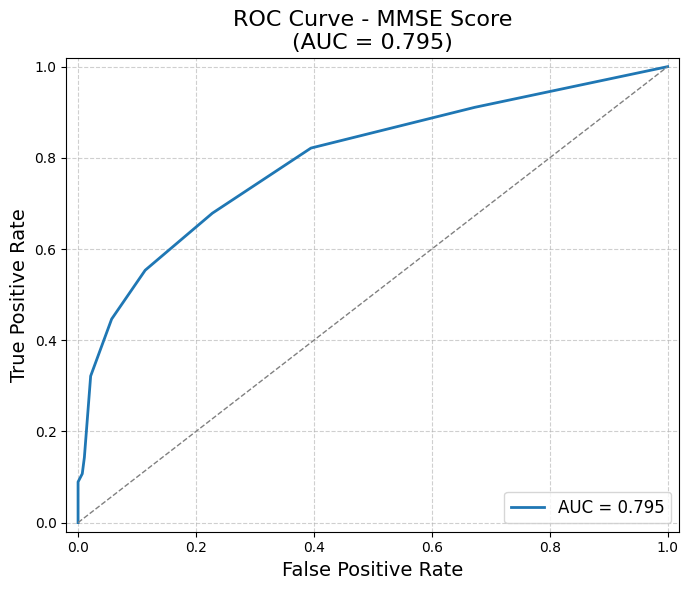

In [28]:
# Define features and target
X_train = df_train[['MMSCORE']]
y_train = df_train['AD']
X_test = df_test[['MMSCORE']]
y_test = df_test['AD']

# Run bootstrapped logistic regression
mmsescore_results = bootstrap_metrics(
    df_train=X_train,
    df_test=X_test,
    independent_vars=['MMSCORE'],
    dep_var_train=y_train,
    dep_var_test=y_test,
    n_bootstrap=1000
)

# Display results
print("\n===== Odds Ratios (one-time fit) — MMSE Score =====")
print(mmsescore_results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {mmsescore_results['Best Threshold']:.2f}")

print("\n===== Bootstrapped Metrics (1000 runs) - MMSE Score =====")
for metric, (mean, ci) in mmsescore_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve
plot_roc_curve(mmsescore_results["True Labels"], mmsescore_results["Predicted Probabilities"], title="ROC Curve - MMSE Score")


## Logistic Regression on MMSE Questions with Bootstrapping

In [29]:
# Logistic Regression on MMSE Questions with Bootstrapping and Best Threshold Search

question_results = []
skipped_questions = []

for question in mmse_cols:
    try:
        # Define features and target
        X_train_question = df_train[[question]]
        y_train_question = df_train['AD']
        X_test_question = df_test[[question]]
        y_test_question = df_test['AD']

        # Run logistic regression with bootstrapping
        results_question = bootstrap_metrics(
            df_train=X_train_question,
            df_test=X_test_question,
            independent_vars=[question],
            dep_var_train=y_train_question,
            dep_var_test=y_test_question,
            n_bootstrap=1000
        )

        # Store results
        question_results.append({
            'Question': question,
            'Best Threshold': results_question['Best Threshold'],
            'Odds Ratios': results_question["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': results_question["Bootstrapped Metrics"],
            'True Labels': results_question["True Labels"],
            'Predicted Probabilities': results_question["Predicted Probabilities"]
        })

    except Exception as e:
        print(f"Error running logistic regression for question {question}: {e}")
        skipped_questions.append({'Question': question, 'Error': str(e)})

# Display results for each question
for result in question_results:
    print(f"\n===== Odds Ratios (one-time fit) — {result['Question']} =====")
    print(result['Odds Ratios'])

    print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")

    print(f"\n===== Bootstrapped Metrics (1000 runs) - {result['Question']} =====")
    for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# Log skipped questions
if skipped_questions:
    print("\n===== Skipped Questions =====")
    for skipped in skipped_questions:
        print(f"Question: {skipped['Question']}, Error: {skipped['Error']}")

# # (Optional) Plot ROC Curve for each question
# for result in question_results:
#     plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Question']}")

# Select good questions based on AUC and p-value thresholds
good_questions, bad_questions = select_good_questions(question_results, pval_threshold=0.05)
print("\n===== Good Questions =====")
for q in good_questions:
    print(q)

print("\n===== Bad Questions =====")
for q in bad_questions:
    print(q)

# Update categories with good questions
updated_categories_questions = update_categories_with_good_questions(categories, good_questions)
print("\n===== Updated Categories with Good Questions =====")
for cat_name, questions in updated_categories_questions.items():
    print(f"{cat_name}: {questions}")



Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.11


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.14


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Error running logistic regression for question WORD1: Singular matrix
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



===== Odds Ratios (one-time fit) — MMYEAR =====
        Odds Ratio  95% CI Lower  95% CI Upper       p-value
const     3.600000      1.336592      9.696303  1.128111e-02
MMYEAR    0.049663      0.018088      0.136354  5.658192e-09

Best Threshold Automatically Found: 0.16

===== Bootstrapped Metrics (1000 runs) - MMYEAR =====
AUC: Mean = 0.5125, 95% CI = [0.5037, 0.5146]
Balanced Accuracy: Mean = 0.5125, 95% CI = [0.5037, 0.5146]
Sensitivity: Mean = 0.0357, 95% CI = [0.0182, 0.0364]
Specificity: Mean = 0.9893, 95% CI = [0.9892, 0.9928]
Precision: Mean = 0.3985, 95% CI = [0.2500, 0.5000]
F1-score: Mean = 0.0655, 95% CI = [0.0339, 0.0678]

===== Odds Ratios (one-time fit) — MMMONTH =====
         Odds Ratio  95% CI Lower  95% CI Upper       p-value
const      3.000000      1.275341      7.056934  1.182792e-02
MMMONTH    0.058257      0.024212      0.140177  2.210977e-10

Best Threshold Automatically Found: 0.15

===== Bootstrapped Metrics (1000 runs) - MMMONTH =====
AUC: Mean = 0.5501, 

## Logistic Regression on MMSE Category with Bootstrapping

Using class weighting automatically.
Best Threshold found automatically: 0.17


/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_31196/2297545758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_31196/2297545758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_31196/2297545758.py:3: SettingWithCop


============ Combined Results ============
----- Odds Ratios (one-time fit) -----
                                   Odds Ratio  95% CI Lower  95% CI Upper  \
const                            2.457445e-81      0.000000           inf   
Orientation_Time_COMPOSITE       3.426769e-01      0.253465      0.463288   
Orientation_Place_COMPOSITE      4.637707e-01      0.294825      0.729529   
Registration_COMPOSITE           7.616571e+28      0.000000           inf   
Attention_Calculation_COMPOSITE  6.547111e-01      0.485426      0.883033   
Recall_COMPOSITE                 5.169778e-01      0.423374      0.631276   
Language_COMPOSITE               6.304347e-01      0.411382      0.966128   
Copy_COMPOSITE                   7.319458e-01      0.347403      1.542140   

                                      p-value  
const                            9.998351e-01  
Orientation_Time_COMPOSITE       3.387871e-12  
Orientation_Place_COMPOSITE      8.861841e-04  
Registration_COMPOSITE         

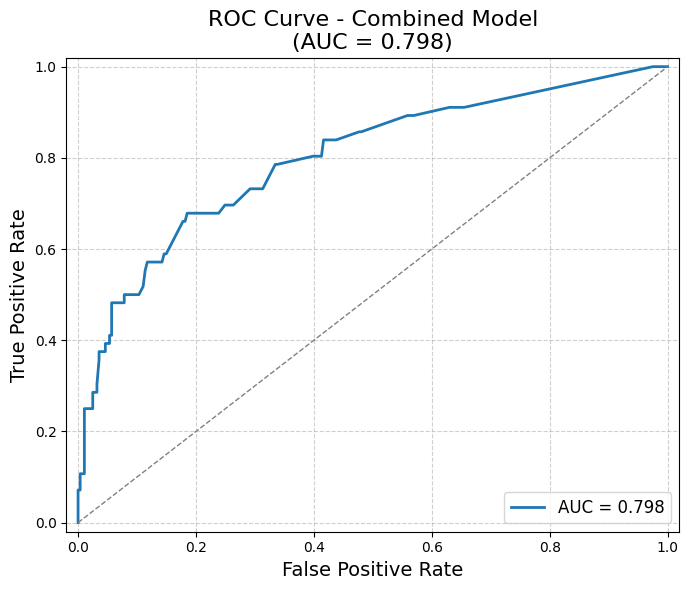


✅ Significant categories selected:
 - Orientation_Time_COMPOSITE
 - Orientation_Place_COMPOSITE
 - Attention_Calculation_COMPOSITE
 - Recall_COMPOSITE
 - Language_COMPOSITE


In [30]:
# Create composite scores for each category
for category, questions in categories.items():
    df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
    df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)

# # Analyze each category
# category_results = []

# for category in categories.keys():
#     print(f"\nRunning logistic regression for category: {category}")

#     try:
#         # Define features and target
#         X_train_category = df_train[[f"{category}_COMPOSITE"]]
#         y_train_category = df_train['AD']
#         X_test_category = df_test[[f"{category}_COMPOSITE"]]
#         y_test_category = df_test['AD']

#         # Run logistic regression with bootstrapping (auto threshold)
#         results_category = bootstrap_metrics(
#             df_train=X_train_category,
#             df_test=X_test_category,
#             independent_vars=[f"{category}_COMPOSITE"],
#             dep_var_train=y_train_category,
#             dep_var_test=y_test_category,
#             n_bootstrap=1000
#         )

#         # Save results
#         category_results.append({
#             'Category': category,
#             'Best Threshold': results_category["Best Threshold"],
#             'Odds Ratios': results_category["Odds Ratios (one-time fit)"],
#             'Bootstrapped Metrics': results_category["Bootstrapped Metrics"],
#             'True Labels': results_category["True Labels"],
#             'Predicted Probabilities': results_category["Predicted Probabilities"]
#         })

#     except Exception as e:
#         print(f"Error running logistic regression for category {category}: {e}")
#         continue

# # Display results for each category
# for result in category_results:
#     print(f"\n============ Results for {result['Category']} ============")
#     print("----- Odds Ratios (one-time fit) -----")
#     print(result['Odds Ratios'])
#     print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
#     print("\n----- Bootstrapped Metrics (1000 runs) -----")
#     for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
#         print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for each category
# for result in category_results:
#    plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Category']}")

# ======= Logistic Regression on Combined Model =======
combined_features = [f"{category}_COMPOSITE" for category in categories.keys()]
X_train_combined = df_train[combined_features]
X_test_combined = df_test[combined_features]
y_train_combined = df_train['AD']
y_test_combined = df_test['AD']

# Run logistic regression on the combined model
combined_category_results = bootstrap_metrics(
    df_train=X_train_combined,
    df_test=X_test_combined,
    independent_vars=[f"{category}_COMPOSITE" for category in categories.keys()],
    dep_var_train=y_train_combined,
    dep_var_test=y_test_combined,
    n_bootstrap=1000
)

# Display combined results
print("\n============ Combined Results ============")
print("----- Odds Ratios (one-time fit) -----")
print(combined_category_results["Odds Ratios (one-time fit)"])
print(f"\nBest Threshold Automatically Found: {combined_category_results['Best Threshold']:.2f}")
print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in combined_category_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for combined model
plot_roc_curve(combined_category_results["True Labels"], combined_category_results["Predicted Probabilities"], title="ROC Curve - Combined Model")

# Analyze p-values of combined model
combined_odds_ratios = combined_category_results["Odds Ratios (one-time fit)"]
significant_categories_ = combined_odds_ratios[(combined_odds_ratios['p-value'] < 0.05) & (~combined_odds_ratios.index.str.contains('const'))].index.tolist()
print(f"\n✅ Significant categories selected:")
for category in significant_categories_:
    print(f" - {category}")

## Logistic Regression on Significant MMSE Category with Bootstrapping


🔎 Correlation matrix between significant categories:
                                  Orientation_Time_COMPOSITE  \
Orientation_Time_COMPOSITE                         1.000000   
Orientation_Place_COMPOSITE                        0.357870   
Attention_Calculation_COMPOSITE                    0.174630   
Recall_COMPOSITE                                   0.415778   
Language_COMPOSITE                                 0.095141   

                                 Orientation_Place_COMPOSITE  \
Orientation_Time_COMPOSITE                          0.357870   
Orientation_Place_COMPOSITE                         1.000000   
Attention_Calculation_COMPOSITE                     0.147989   
Recall_COMPOSITE                                    0.293434   
Language_COMPOSITE                                  0.152234   

                                 Attention_Calculation_COMPOSITE  \
Orientation_Time_COMPOSITE                              0.174630   
Orientation_Place_COMPOSITE                  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Significant Combined Model ============
----- Odds Ratios (one-time fit) -----
                                    Odds Ratio  95% CI Lower  95% CI Upper  \
const                            404239.467499   5707.062523  2.863286e+07   
Orientation_Time_COMPOSITE            0.366535      0.274015  4.902938e-01   
Orientation_Place_COMPOSITE           0.466215      0.299230  7.263862e-01   
Attention_Calculation_COMPOSITE       0.627587      0.471508  8.353302e-01   
Recall_COMPOSITE                      0.521653      0.428073  6.356919e-01   
Language_COMPOSITE                    0.675502      0.442353  1.031534e+00   

                                      p-value  
const                            2.864661e-09  
Orientation_Time_COMPOSITE       1.360848e-11  
Orientation_Place_COMPOSITE      7.437902e-04  
Attention_Calculation_COMPOSITE  1.406803e-03  
Recall_COMPOSITE                 1.110436e-10  
Language_COMPOSITE               6.933577e-02  

Best Thresh

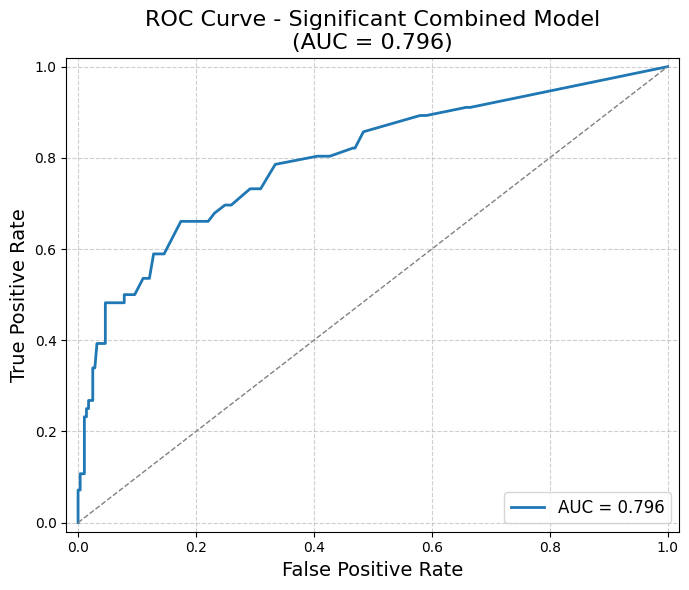

In [31]:
# Prepare train and test data for combined model
X_train_significant = df_train[significant_categories_]
X_test_significant = df_test[significant_categories_]
y_train_significant = df_train['AD']
y_test_significant = df_test['AD']

# Check correlations
corr_matrix = X_train_significant.corr()
print("\n🔎 Correlation matrix between significant categories:\n", corr_matrix)

# Remove highly correlated composites (>0.90)
features_to_drop = drop_highly_correlated_features(X_train_significant, threshold=0.90)

# Drop them
X_train_final = X_train_significant.drop(columns=features_to_drop)
X_test_final = X_test_significant.drop(columns=features_to_drop)
print(f"\nDropped features due to high correlation: {features_to_drop}")

# Run logistic regression on significant combined model
significant_combined_results = bootstrap_metrics(
    df_train=X_train_final,
    df_test=X_test_final,
    independent_vars=X_train_final.columns.tolist(),
    dep_var_train=y_train_significant,
    dep_var_test=y_test_significant,
    n_bootstrap=1000
)

# Display new combined model
print("\n============ Results for Significant Combined Model ============")
print("----- Odds Ratios (one-time fit) -----")
print(significant_combined_results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {significant_combined_results['Best Threshold']:.2f}")

print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in significant_combined_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# Plot ROC Curve
plot_roc_curve(significant_combined_results["True Labels"], significant_combined_results["Predicted Probabilities"], title="ROC Curve - Significant Combined Model"
)

## Logisitc Regression on Significant Categories with "Good" Questions

/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_31196/340342685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_31196/340342685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_31196/340342685.py:3: SettingWithCopyWa

Using class weighting automatically.
Best Threshold found automatically: 0.22

============ Combined Results ============
----- Odds Ratios (one-time fit) -----
                                   Odds Ratio  95% CI Lower  95% CI Upper  \
const                            54261.983790   1159.445687  2.539457e+06   
Orientation_Time_COMPOSITE           0.372158      0.278482  4.973433e-01   
Orientation_Place_COMPOSITE          0.462792      0.297223  7.205935e-01   
Attention_Calculation_COMPOSITE      0.609714      0.457952  8.117691e-01   
Recall_COMPOSITE                     0.511010      0.419974  6.217804e-01   
Language_COMPOSITE                   0.644872      0.179580  2.315740e+00   

                                      p-value  
const                            2.764451e-08  
Orientation_Time_COMPOSITE       2.369745e-11  
Orientation_Place_COMPOSITE      6.487136e-04  
Attention_Calculation_COMPOSITE  7.041382e-04  
Recall_COMPOSITE                 1.989558e-11  
Language_CO

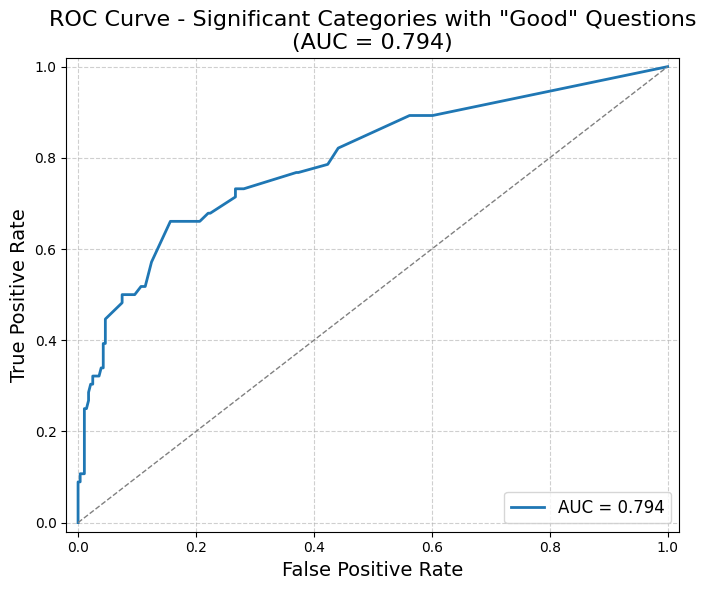

In [ ]:
# Create composite scores for each category
for category, questions in updated_categories.items():
    df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
    df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)

# Analyze each category
category_results = []

# for category in updated_categories.keys():
#     print(f"\nRunning logistic regression for category: {category}")

#     try:
#         # Define features and target
#         X_train_category = df_train[[f"{category}_COMPOSITE"]]
#         y_train_category = df_train['AD']
#         X_test_category = df_test[[f"{category}_COMPOSITE"]]
#         y_test_category = df_test['AD']

#         # Prepare features for logistic regression
#         #X_train_category, X_test_category = prepare_embeddings_for_logistic_regression(X_train_category, X_test_category)

#         # Run logistic regression with bootstrapping (auto threshold)
#         results_category = bootstrap_metrics(
#             df_train=X_train_category,
#             df_test=X_test_category,
#             independent_vars=[f"{category}_COMPOSITE"],
#             dep_var_train=y_train_category,
#             dep_var_test=y_test_category,
#             n_bootstrap=1000
#         )

#         # Save results
#         category_results.append({
#             'Category': category,
#             'Best Threshold': results_category["Best Threshold"],
#             'Odds Ratios': results_category["Odds Ratios (one-time fit)"],
#             'Bootstrapped Metrics': results_category["Bootstrapped Metrics"],
#             'True Labels': results_category["True Labels"],
#             'Predicted Probabilities': results_category["Predicted Probabilities"]
#         })

#     except Exception as e:
#         print(f"Error running logistic regression for category {category}: {e}")
#         continue

# # Display results for each category
# for result in category_results:
#     print(f"\n============ Results for {result['Category']} ============")
#     print("----- Odds Ratios (one-time fit) -----")
#     print(result['Odds Ratios'])
#     print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
#     print("\n----- Bootstrapped Metrics (1000 runs) -----")
#     for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
#         print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for each category
# for result in category_results:
#    plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Category']}")

# ======= Logistic Regression on Combined Model =======
combined_features = [f"{category}_COMPOSITE" for category in updated_categories.keys()]
X_train_combined = df_train[combined_features]
X_test_combined = df_test[combined_features]
y_train_combined = df_train['AD']
y_test_combined = df_test['AD']

# Run logistic regression on the combined model
updated_category_results = bootstrap_metrics(
    df_train=X_train_combined,
    df_test=X_test_combined,
    independent_vars=[f"{category}_COMPOSITE" for category in updated_categories.keys()],
    dep_var_train=y_train_combined,
    dep_var_test=y_test_combined,
    n_bootstrap=1000
)

# Display combined results
print("\n============ Combined Results ============")
print("----- Odds Ratios (one-time fit) -----")
print(updated_category_results["Odds Ratios (one-time fit)"])
print(f"\nBest Threshold Automatically Found: {updated_category_results['Best Threshold']:.2f}")
print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in updated_category_results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for combined model
plot_roc_curve(updated_category_results["True Labels"], updated_category_results["Predicted Probabilities"], title='ROC Curve - Fully Optimized Feature Set')

## Logisitc Regression on Numerical ClinicalBERT Embeddings 


Running combined logistic regression for Numerical ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.43


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for Numerical ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                               Odds Ratio  95% CI Lower  \
const                                        3.641184e+08  5.758715e+02   
Orientation_Time_Numerical_Embedding_0       9.847206e-06  3.119673e-09   
Orientation_Place_Numerical_Embedding_0      3.012944e-08  7.901494e-15   
Attention_Calculation_Numerical_Embedding_0  8.259250e-06  1.197759e-09   
Recall_Numerical_Embedding_0                 6.368384e-04  1.446644e-05   
Language_Numerical_Embedding_0               2.493804e-01  2.185573e-09   

                                             95% CI Upper   p-value  
const                                        2.302288e+14  0.003821  
Orientation_Time_Numerical_Embedding_0       3.108257e-02  0.005042  
Orientation_Place_Numerical_Embedding_0      1.148875e-01  0.025102  
Attention_Calculation_Numerical_Embedding_0  5.695239e-02  0.009448  
Recall_Numerical_Embedding_0   

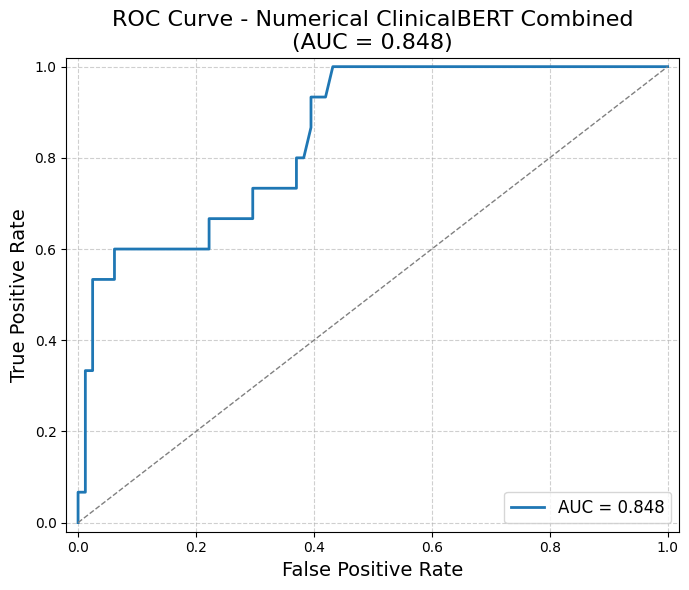

In [34]:
numerical_clinicalbert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_clinicalbert_train,
    test_df=df_numerical_clinicalbert_test,
    embedding_cols=[col for col in df_numerical_clinicalbert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=updated_categories,
    model_name="Numerical ClinicalBERT",
    n_bootstrap=1000
)

## Logistic regression on ClinicalBERT embeddings.


Running combined logistic regression for ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Combined Results for ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                 Odds Ratio  95% CI Lower  95% CI Upper  \
const                          3.240989e-08           0.0           inf   
Orientation_Time_Embedding_0   2.141310e+09           0.0           inf   
Orientation_Time_Embedding_1   5.959534e-03           0.0           inf   
Orientation_Time_Embedding_4   9.057726e+06           0.0           inf   
Orientation_Time_Embedding_14  3.869521e-06           0.0           inf   
...                                     ...           ...           ...   
Language_Embedding_12          6.390793e+00           0.0           inf   
Language_Embedding_18          1.807180e+03           NaN           NaN   
Language_Embedding_19          3.043414e+02           0.0           inf   
Language_Embedding_103         2.067298e+05           0.0           inf   
Language_Embedding_107         2.801582e+05           0.0           inf   

                

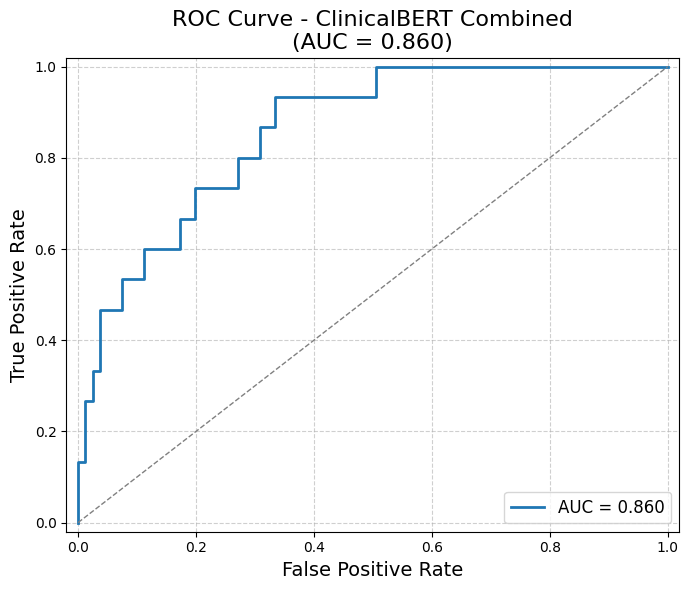

In [36]:
clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_clincalbert_train,
    test_df=df_clincalbert_test,
    embedding_cols=[col for col in df_clincalbert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="ClinicalBERT"
)


## Logistic Regression on Contextual ClinicalBERT embeddings


Running combined logistic regression for Contextual ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Combined Results for Contextual ClinicalBERT ===

----- Odds Ratios (one-time fit) -----
                                          Odds Ratio  95% CI Lower  \
const                                  1.307971e+117           NaN   
Orientation_Time_Context_Embedding_0    0.000000e+00           NaN   
Orientation_Time_Context_Embedding_1             inf           NaN   
Orientation_Time_Context_Embedding_29  2.624763e-184           NaN   
Orientation_Time_Context_Embedding_35  1.036397e+106           0.0   
...                                              ...           ...   
Language_Context_Embedding_2            3.739388e+04           NaN   
Language_Context_Embedding_5            3.280870e-10           NaN   
Language_Context_Embedding_204          7.828626e+18           0.0   
Language_Context_Embedding_245          3.320263e+40           NaN   
Language_Context_Embedding_467          1.750486e-22           0.0   

                                       95% CI Upper   p-value  
c

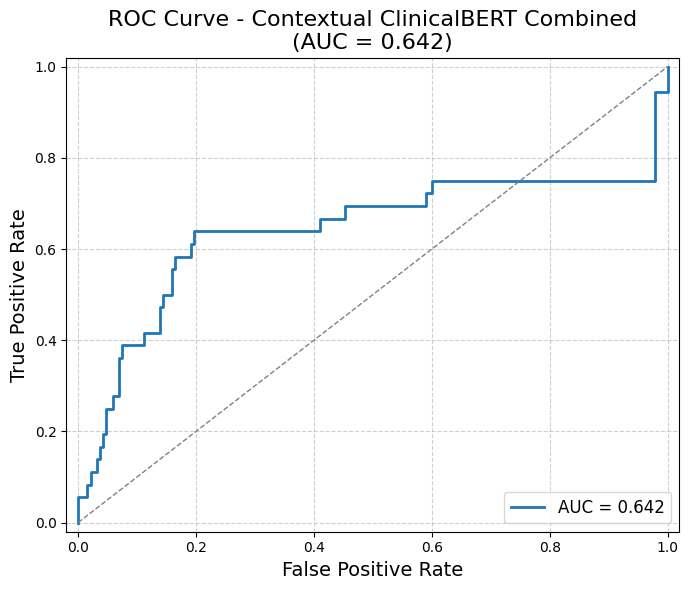

In [37]:
context_clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_clinicalbert_train,
    test_df=df_context_clinicalbert_test,
    embedding_cols=[col for col in df_context_clinicalbert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual ClinicalBERT"
)


## Logisitc Regression on Numerical BioBERT Embeddings


Running combined logistic regression for Numerical BioBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.43


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for Numerical BioBERT ===

----- Odds Ratios (one-time fit) -----
                                               Odds Ratio  95% CI Lower  \
const                                        2.200596e+11  8.940803e+03   
Orientation_Time_Numerical_Embedding_0       9.900898e-06  3.148627e-09   
Orientation_Place_Numerical_Embedding_0      3.037656e-08  8.023447e-15   
Attention_Calculation_Numerical_Embedding_0  8.304972e-06  1.209421e-09   
Recall_Numerical_Embedding_0                 6.390528e-04  1.454268e-05   
Language_Numerical_Embedding_0               2.495438e-01  2.206227e-09   

                                             95% CI Upper   p-value  
const                                        5.416316e+18  0.002632  
Orientation_Time_Numerical_Embedding_0       3.113350e-02  0.005042  
Orientation_Place_Numerical_Embedding_0      1.150048e-01  0.025102  
Attention_Calculation_Numerical_Embedding_0  5.702942e-02  0.009448  
Recall_Numerical_Embedding_0        

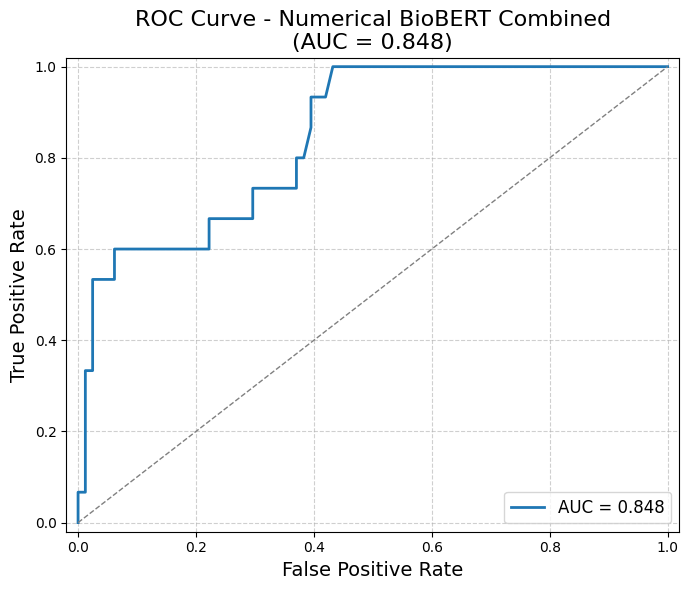

In [38]:
numerical_biobert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_biobert_train,
    test_df=df_numerical_biobert_test,
    embedding_cols=[col for col in df_numerical_biobert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=updated_categories,
    model_name="Numerical BioBERT",
    n_bootstrap=1000
)

## Logistic Regression on BioBert embeddings


Running combined logistic regression for BioBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.52


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for BioBERT ===

----- Odds Ratios (one-time fit) -----
                                     Odds Ratio  95% CI Lower   95% CI Upper  \
const                              1.478766e+25  3.917855e+03   5.581492e+46   
Orientation_Time_Embedding_0       8.857108e-05  4.506726e-49   1.740695e+40   
Orientation_Time_Embedding_354     4.857364e+97  2.863562e-09  8.239385e+203   
Orientation_Place_Embedding_0      1.184023e-44  2.395713e-89   5.851742e+00   
Attention_Calculation_Embedding_0  1.100357e-29  1.340882e-49   9.029767e-10   
Recall_Embedding_0                 1.132498e-47  5.675334e-73   2.259870e-22   
Language_Embedding_6               1.334132e+03  3.867397e-33   4.602342e+38   

                                    p-value  
const                              0.022234  
Orientation_Time_Embedding_0       0.857678  
Orientation_Time_Embedding_354     0.071492  
Orientation_Place_Embedding_0      0.054065  
Attention_Calculation_Embedding_0  0.004370  
Recal

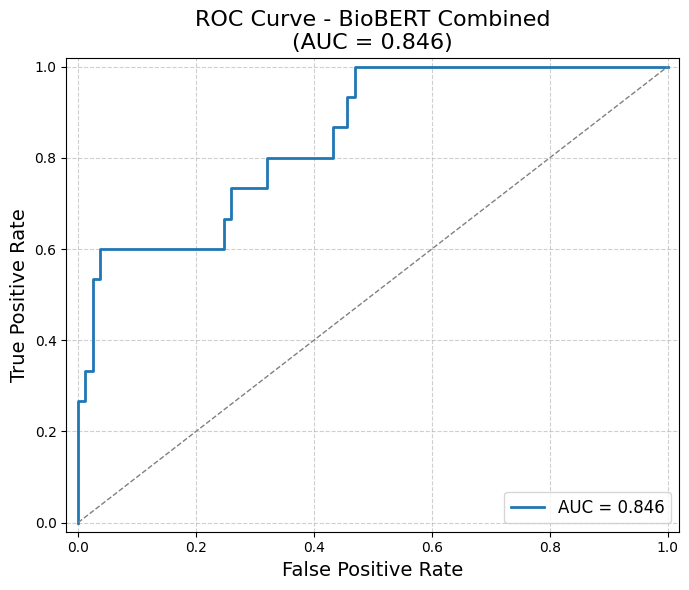

In [39]:
biobert_combined_result = run_logistic_regression_pipeline(
    train_df=df_biobert_train,
    test_df=df_biobert_test,
    embedding_cols=[col for col in df_biobert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="BioBERT"
)

## Logistic Regression on Contextual BioBert embeddings

In [ ]:
# context_biobert_combined_result = run_logistic_regression_pipeline(
#     train_df=df_context_biobert_train,
#     test_df=df_context_biobert_test,
#     embedding_cols=[col for col in df_context_biobert_train.columns if col.startswith('Context_Embedding_')],
#     categories=updated_categories,
#     model_name="Contextual BioBERT"
# )


Running combined logistic regression for Contextual BioBERT (mean embeddings per category)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

## Logisitic Regression on Numerical MedBERT Embeddings


Running combined logistic regression for Numerical MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.43


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Combined Results for Numerical MedBERT ===

----- Odds Ratios (one-time fit) -----
                                               Odds Ratio  95% CI Lower  \
const                                        3.350520e+14  2.054647e+05   
Orientation_Time_Numerical_Embedding_0       5.922686e-04  3.287097e-06   
Orientation_Place_Numerical_Embedding_0      1.418081e-05  8.113012e-10   
Attention_Calculation_Numerical_Embedding_0  5.287939e-04  1.773423e-06   
Recall_Numerical_Embedding_0                 8.704988e-03  7.589338e-04   
Language_Numerical_Embedding_0               4.085045e-01  2.613294e-06   

                                             95% CI Upper   p-value  
const                                        5.463704e+23  0.002000  
Orientation_Time_Numerical_Embedding_0       1.067149e-01  0.005042  
Orientation_Place_Numerical_Embedding_0      2.478676e-01  0.025102  
Attention_Calculation_Numerical_Embedding_0  1.576742e-01  0.009448  
Recall_Numerical_Embedding_0        

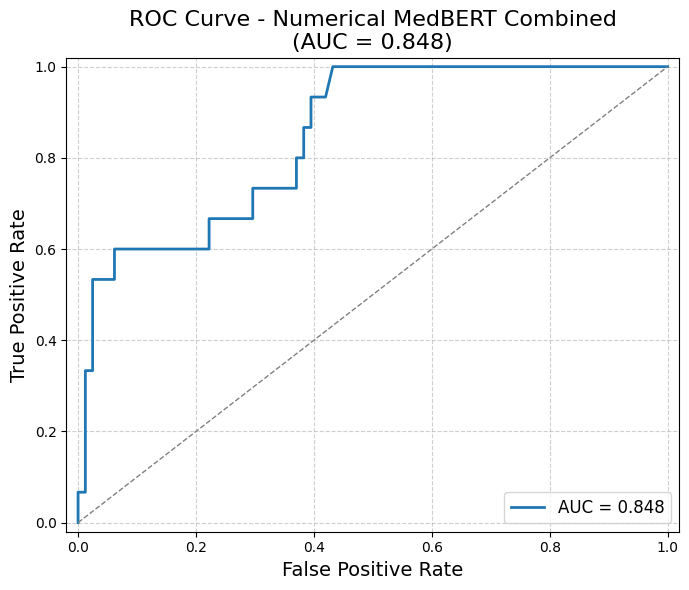

In [41]:
numerical_medbert_combined_results = run_logistic_regression_pipeline(
    train_df=df_numerical_medbert_train,
    test_df=df_numerical_medbert_test,
    embedding_cols=[col for col in df_numerical_medbert_train.columns if col.startswith("Numerical_Embedding_")],
    categories=updated_categories,
    model_name="Numerical MedBERT",
    n_bootstrap=1000
)

## Logistic Regression on MedBERT embeddings


Running combined logistic regression for MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.78


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge


=== Combined Results for MedBERT ===

----- Odds Ratios (one-time fit) -----
                              Odds Ratio  95% CI Lower  95% CI Upper   p-value
const                                0.0           0.0           inf  0.949973
Orientation_Time_Embedding_0         0.0           NaN           NaN       NaN
Orientation_Time_Embedding_1         inf           0.0           inf  0.998992
Orientation_Time_Embedding_2         inf           0.0           inf  0.964630
Orientation_Time_Embedding_3         inf           0.0           inf  0.996594
...                                  ...           ...           ...       ...
Language_Embedding_3                 0.0           0.0           inf  0.968396
Language_Embedding_4                 0.0           NaN           NaN       NaN
Language_Embedding_8                 0.0           0.0           inf  0.995845
Language_Embedding_69                inf           0.0           inf  0.363515
Language_Embedding_82                0.0           0.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Pytho

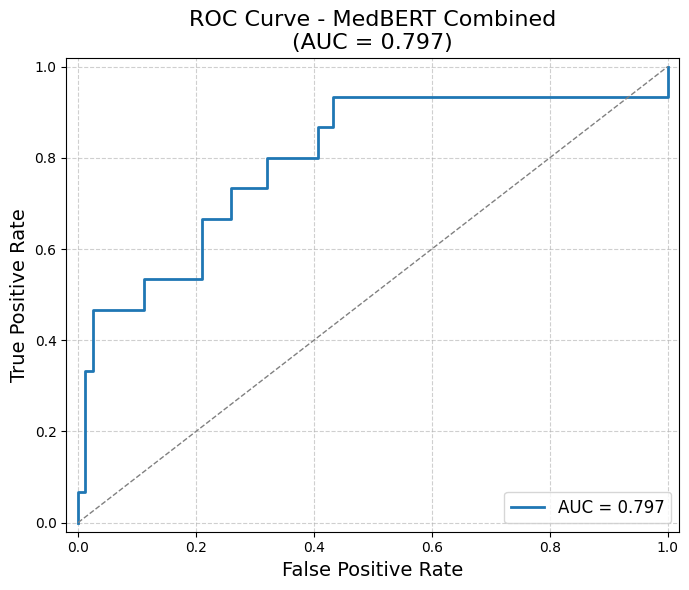

In [42]:
medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_medbert_train,
    test_df=df_medbert_test,
    embedding_cols=[col for col in df_medbert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="MedBERT"
)

## Logisitc Regression on Contextual MedBERT embeddings


Running combined logistic regression for Contextual MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.45


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge


=== Combined Results for Contextual MedBERT ===

----- Odds Ratios (one-time fit) -----
                                          Odds Ratio  95% CI Lower  \
const                                            inf           0.0   
Orientation_Time_Context_Embedding_0    0.000000e+00           NaN   
Orientation_Time_Context_Embedding_5    0.000000e+00           NaN   
Orientation_Time_Context_Embedding_6    0.000000e+00           0.0   
Orientation_Time_Context_Embedding_13            inf           0.0   
...                                              ...           ...   
Language_Context_Embedding_2            0.000000e+00           NaN   
Language_Context_Embedding_7           2.558431e-163           0.0   
Language_Context_Embedding_31                    inf           NaN   
Language_Context_Embedding_43                    inf           0.0   
Language_Context_Embedding_53           0.000000e+00           NaN   

                                       95% CI Upper   p-value  
const 

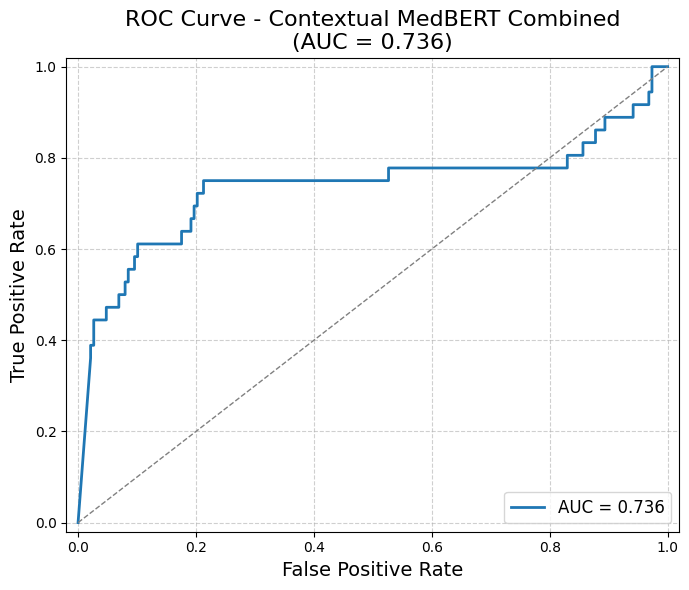

In [43]:
context_medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_medbert_train,
    test_df=df_context_medbert_test,
    embedding_cols=[col for col in df_context_medbert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual MedBERT"
)

## Display the results from each model

In [44]:
import pandas as pd

# Collect results from each combined model
combined_model_results = [
                        mmsescore_results,
                        combined_category_results,
                        significant_combined_results,
                        updated_category_results,
                        numerical_clinicalbert_combined_results,
                        clinicalbert_combined_result,
                        context_clinicalbert_combined_result,
                        numerical_biobert_combined_results,
                        biobert_combined_result,
                        # context_biobert_combined_result,
                        numerical_medbert_combined_results,
                        medbert_combined_result,
                        context_medbert_combined_result
                         ]
# Define model names
combined_model_names = [
                    'MMSE Score',
                    'MMSE Categories',
                    'Significant MMSE Categories',
                    'Updated Significant MMSE Categories',
                    'Numerical ClinicalBERT',
                    'ClinicalBERT',
                    'Contextual ClinicalBERT',
                    'Numerical BioBERT',
                    'BioBERT',
                    # 'Contextual BioBERT',
                    'Numerical MedBERT',
                    'MedBERT',
                    'Contextual MedBERT'
                    ]

# Initialize list to store summary rows
summary_rows = []

for result, name in zip(combined_model_results, combined_model_names):
    row = {'Model': name}

    # # Extract odds ratios
    # odds_ratios = result['Odds Ratios (one-time fit)']
    # row['Odds Ratios'] = odds_ratios.to_dict()

    # Extract best threshold
    row['Best Threshold'] = result.get('Best Threshold', None)

    # Extract bootstrapped metrics
    for metric_name, (mean, ci) in result['Bootstrapped Metrics'].items():
        row[f'{metric_name}'] = round(mean, 4)
        # row[f'{metric_name} 95% CI Lower'] = round(ci[0], 4)
        # row[f'{metric_name} 95% CI Upper'] = round(ci[1], 4)

    summary_rows.append(row)

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_rows)

# Display the summary DataFrame
from IPython.display import display
print("=== Summary of Combined Model Results ===")
display(summary_df)

# Save the summary DataFrame to a CSV file
summary_df.to_csv("data/Combined_Model_Metrics_Summary.csv", index=False)


=== Summary of Combined Model Results ===


,Model,Best Threshold,AUC,Balanced Accuracy,Sensitivity,Specificity,Precision,F1-score
0,MMSE Score,0.12,0.7946,0.7253,0.6783,0.7723,0.3716,0.4802
1,MMSE Categories,0.17,0.7980,0.7449,0.6783,0.8114,0.4167,0.5162
2,Significant MMSE Categories,0.18,0.7948,0.7413,0.6604,0.8221,0.4244,0.5167
3,Updated Significant MMSE Categories,0.22,0.7937,0.7519,0.6604,0.8435,0.4558,0.5394
4,Numerical ClinicalBERT,0.43,0.8479,0.7690,0.5997,0.9382,0.6387,0.6182
5,ClinicalBERT,0.10,0.8599,0.7678,0.7329,0.8027,0.4034,0.5202
6,Contextual ClinicalBERT,0.12,0.6416,0.7182,0.6385,0.7979,0.3754,0.4728
7,Numerical BioBERT,0.43,0.8479,0.7690,0.5997,0.9382,0.6387,0.6182
8,BioBERT,0.52,0.8461,0.7813,0.5997,0.9629,0.7465,0.6646
9,Numerical MedBERT,0.43,0.8483,0.7690,0.5997,0.9382,0.6387,0.6182


In [45]:
# Extract and display Odds Ratios for combined_category_results
import pandas as pd

# Assuming combined_category_results is already computed
odds_ratios = updated_category_results["Odds Ratios (one-time fit)"]

# Convert to DataFrame if not already
if isinstance(odds_ratios, dict):
    odds_ratios_df = pd.DataFrame.from_dict(odds_ratios, orient='index', columns=['Odds Ratio'])
else:
    odds_ratios_df = odds_ratios

# Display the table
print("=== Odds Ratios for Combined Category Results ===")
print(odds_ratios_df)

# Save to CSV (optional)
# odds_ratios_df.to_csv("data/Odds_Ratios_Combined_Category_Results.csv", index=True)

=== Odds Ratios for Combined Category Results ===
                                   Odds Ratio  95% CI Lower  95% CI Upper  \
const                            54261.983790   1159.445687  2.539457e+06   
Orientation_Time_COMPOSITE           0.372158      0.278482  4.973433e-01   
Orientation_Place_COMPOSITE          0.462792      0.297223  7.205935e-01   
Attention_Calculation_COMPOSITE      0.609714      0.457952  8.117691e-01   
Recall_COMPOSITE                     0.511010      0.419974  6.217804e-01   
Language_COMPOSITE                   0.644872      0.179580  2.315740e+00   

                                      p-value  
const                            2.764451e-08  
Orientation_Time_COMPOSITE       2.369745e-11  
Orientation_Place_COMPOSITE      6.487136e-04  
Attention_Calculation_COMPOSITE  7.041382e-04  
Recall_COMPOSITE                 1.989558e-11  
Language_COMPOSITE               5.012176e-01  


## ROC Curves for the different models

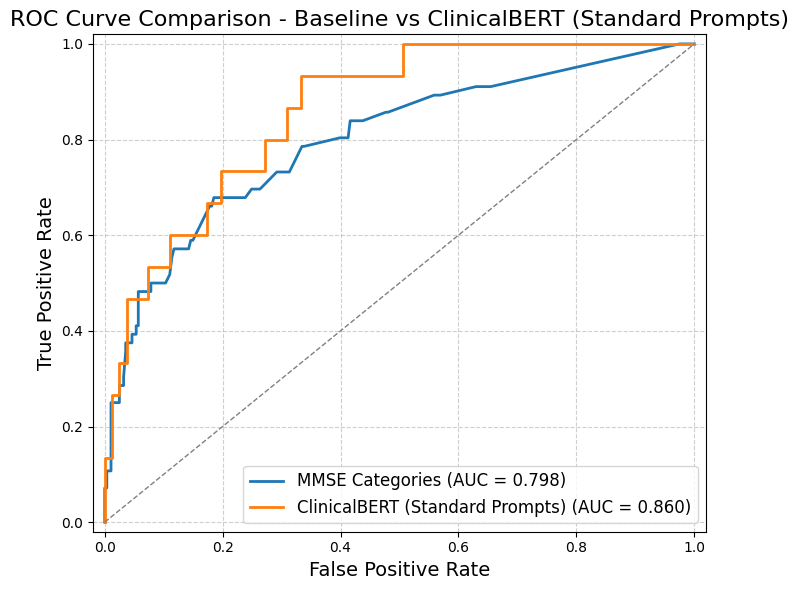

In [49]:
# Function to plot ROC Curves for specified models (Styled)
def plot_roc_curves(model_results, title='ROC Curve'):
    plt.figure(figsize=(7, 6))

    for model_name, (y_true, y_scores) in model_results.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

    # Random Chance line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    # Plot settings
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f"{title}", fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Function to plot both Baslines and ClinicalBERT (Standard Prompts) ROC Curves
def plot_combined_roc():
    model_results = {
        'MMSE Categories': (combined_category_results["True Labels"], combined_category_results["Predicted Probabilities"]),
        'ClinicalBERT (Standard Prompts)': (clinicalbert_combined_result["True Labels"], clinicalbert_combined_result["Predicted Probabilities"]),
    }
    plot_roc_curves(model_results, title='ROC Curve Comparison - Baseline vs ClinicalBERT (Standard Prompts)')

# Plot both Baslines and ClinicalBERT (Contextual Prompts) ROC Curves
plot_combined_roc()


## Confusion Matrix

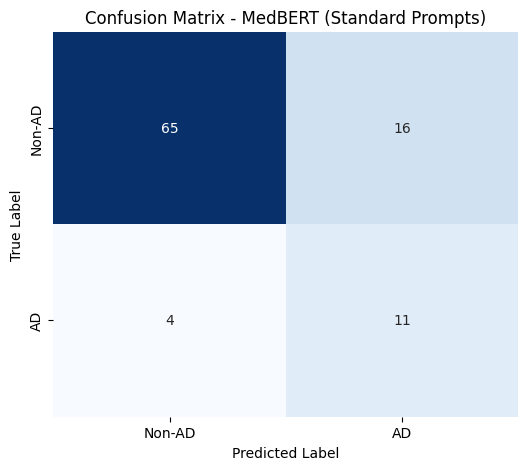

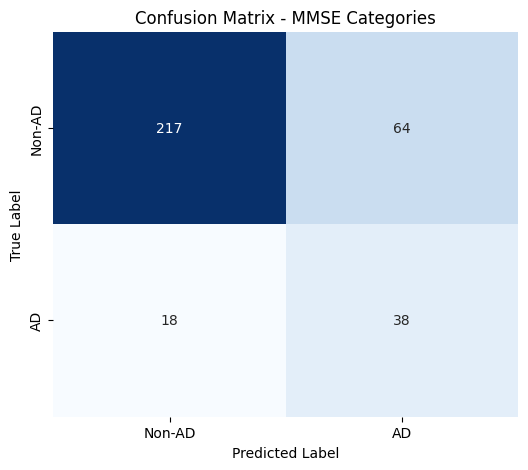

In [50]:
# Generate Confusion Matrix for ClincalBERT
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-AD', 'AD'], yticklabels=['Non-AD', 'AD'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Generate confusion matrix for MedBERT (standard prompts)
y_true = clinicalbert_combined_result["True Labels"]
y_pred = (clinicalbert_combined_result["Predicted Probabilities"] > clinicalbert_combined_result['Best Threshold']).astype(int)
plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix - MedBERT (Standard Prompts)')

# Generate confusion matrix for Combined MMSE Categories
combined_y_true = mmsescore_results["True Labels"]
combined_y_pred = (mmsescore_results["Predicted Probabilities"] > combined_category_results['Best Threshold']).astype(int)
plot_confusion_matrix(combined_y_true, combined_y_pred, title='Confusion Matrix - MMSE Categories')